### Sources and inspiration:
Emil Wallner blog post and code on Floydhub for image colorization

"Deep Koalarization": https://github.com/baldassarreFe/deep-koalarization

"Colorful Image Colorization": https://github.com/richzhang/colorization


## Running the notebook
We used the command:

```floyd run --gpu --tensorboard --env tensorflow:py2 --data emilwallner/datasets/colornet/2:train_data --mode jupyter```

The ```--data``` flag along with Wallner's dataset will make this notebook work best, but it should be okay even without.

__IMPORTANT:__

There's a couple places in this notebook where we've marked out some booleans with two rows of ############## above and below; these are flags that remove or modify files and/or decide the execution of the cell. Double check that these are what you want them to be to ensure you don't accidentally mess up the execution of the cells, etc.

## 1. Setup Cells

## 1a. Compatibility: dependencies, Python 2 vs. 3

Needed this keras installation hack to run on FloydHub; importing keras and trying to obtain the InceptionResNetv2 doesn't work otherwise on their platform.

In [1]:
# Note: You need to reset the kernel after the keras installation to take place
# Remove this line once it is installed, reset the kernel: Menu > Kernel > Reset & Clear Output
# Uncomment this line and run this cell once, at the beginning of the kernel.

# ! rm -rf keras
# ! git clone https://github.com/fchollet/keras.git && cd keras && python setup.py install --user
# ! cd ..

In [2]:
import sys

# Sometimes, some problems come up because the machine running this notebook
# doesn't have Keras, h5py, etc. We install those dependencies here.

# If you've installed keras from cloning the Github, this below line is unnecessary.
! pip install keras
! pip install h5py

# Python 3 peculiarities
if sys.version_info[0] == 3:
    xrange = range

## 1b. Janitorial work
Cleaning up directories so we can start anew. Uncomment and run this only if you know you have data in these directories from a previous run, etc. that you want to remove and start fresh.

In [3]:
rainbow_dir = "rainbownet/"

# Look at the environment.
print("Current directory:\n")
! ls

print("\n=============\nIn rainbownet/:\n")
! ls {rainbow_dir}

#################
remove = False
#################

if remove:
  ! rm -rf {rainbow_dir}
  ! mkdir {rainbow_dir}
  ! ls {rainbow_dir}

Current directory:

command.sh  keras  logs  rainbownet  rainbownet_v6.ipynb

In rainbownet/:

data  metadata	model_params  results  tmp


## 1c. Paths used in the model
Paths that we need are listed here. If they don't exist, we create them.

In [4]:
import os

# Paths and utilities
# -------------------
# Assuming this notebook's directory (<repository root>/model) is root.
data_dir = rainbow_dir + "data/"
train_dir = data_dir + "Train/"
validation_dir = data_dir + "Validation/"
test_dir = data_dir + "Test/"
results_dir = rainbow_dir + "results/"
temp_dir = rainbow_dir + "tmp/"
gif_train_dir = temp_dir + "gif_train/"
logs_dir = "logs/"
model_chkpt = rainbow_dir + "model_params/"
model_metadata_dir = rainbow_dir + "metadata/"

required_directories = [
    train_dir,
    validation_dir,
    test_dir,
    results_dir,
    gif_train_dir,
    model_chkpt,
    model_metadata_dir,
    logs_dir
]


def create_unexisting_directories(dirs):
  for path in dirs:
    if not os.path.isdir(path):
      print("Didn't find the path '%s'. Creating it now." % path)
      # NOTE: os.makedirs() is recursive.
      os.makedirs(path)
    else:
      print("%s exists." % path)

create_unexisting_directories(required_directories)

rainbownet/data/Train/ exists.
rainbownet/data/Validation/ exists.
rainbownet/data/Test/ exists.
rainbownet/results/ exists.
rainbownet/tmp/gif_train/ exists.
rainbownet/model_params/ exists.
rainbownet/metadata/ exists.
logs/ exists.


## 1d. Imports

In [5]:
"""
Above:
import os
import sys """
import numpy as np
import random
import tensorflow as tf

# misc for functions below
from IPython.display import Image as iPyImage
from PIL import Image
import requests
import urllib
from datetime import datetime
from collections import defaultdict

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave

import matplotlib
# This line was for some of our machines; some edge case
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

import keras
import keras.backend as K
from keras.activations import softmax
from keras.callbacks import TensorBoard
from keras.layers.core import RepeatVector
from keras.layers import Conv2D, UpSampling2D, InputLayer, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from keras.layers.core import Lambda
from keras.layers.normalization import BatchNormalization
from keras.metrics import top_k_categorical_accuracy
from keras.models import Model, Sequential
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input

Using TensorFlow backend.


## 1e. Pre-defined Constants, Global variables

In [6]:
model_name = "rainbownet"

# Debugging
globalname = "res"
globalnameidx = 0
completed_epochs = 0

# Adjustable constants
BATCH_SIZE = 32
GRID_SIZE = 16
NUM_TOTAL_BUCKETS = (256//GRID_SIZE)**2

NUM_VALID_BUCKETS = 112      # NUM_VALID_BUCKETS will be updated dynamically if inconsistent
BUCKET_ID_TO_INDEX = None    # helper dict for AB color discretization
BUCKET_INDEX_TO_ID = None    # helper dict for AB color discretization


# 2. Helper Functions
Stuff we're using in the other functions below.

In [32]:
# Examples of use:
# load_data(train_dir)
# load_data(test_dir)

def load_data(directory):
    """ Load an entire set of |m| examples of images from a directory. 
    """
    images = []
    for filename in os.listdir(directory):
      image = load_img(directory + filename)  # PIL image
      images.append(img_to_array(image))      # np.array

    images = np.array(images, dtype=int)
    return images

def resize_images(images, shape):
  """ Resizes images to a given shape.
      |shape|: a 3-tuple of the dimensions to resize to. 
               (H, W, 3) usually.
  """
  # Sanity check for dims
  assert len(shape) == 3 and shape[2] == 3
  
  resized = []
  for i in images:
    im = resize(i, shape, mode='constant')
    resized.append(im)
  resized = np.array(resized)
  return resized


# A debugging function.
def analyze_images(images):
  # 4d images
  L = images[:,:,:,0]
  A = images[:,:,:,1]
  B = images[:,:,:,2]
  print("stats on channel1: min %s, max %s" % (np.amin(L), np.amax(L)))
  print("stats on channel2: min %s, max %s" % (np.amin(A), np.amax(A)))
  print("stats on channel3: min %s, max %s" % (np.amin(B), np.amax(B)))
  
def nextGlobalName():
  global globalname
  global globalnameidx
  name = globalname + str(globalnameidx)
  globalnameidx += 1
  return name

def debug(obj, name=None, plimit=500):
  if name is None:
    name = nextGlobalName()
  typ = type(obj)
  typstr = str(typ)

  # for debugging ndarray shape or length of something
  shape = "(N/A)"
  if typ == type(np.array([0])):
    shape = obj.shape
  else:
    try:
      shape = "len=" + str(len(obj))
    except TypeError:
      pass
  shapestr = str(shape)

  objstr = str(obj)
  objout = objstr if len(objstr) < plimit \
                  else objstr[:plimit] + "\n[... %s output truncated]" % name

  outputs = [typstr, shapestr, name + ":\n", objout]
  print " ".join(outputs)


# Getting a file from online
# --------------------------
# Taken from
# "https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive"
#
# example usage:
# download_file_from_google_drive("1H5aWTvlodzLA_hwm68BHtJbrvuKYt0hh", "test.jpg")

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768
        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

# 3. Populate our training directory with images


## 3a. Relocate the dataset passed in from FloydHub
The floyd command allows us to pass in a dataset when we start a job. Because we can only put it relative to the root, move it into our train dir.

In [ ]:
# If we mount FloydHub's dataset from Emil Wallner's colornet
#   at /train_data, set this to True

##########################################
should_retrieve_fh_emilwallner_data = True
##########################################

if should_retrieve_fh_emilwallner_data:
  
  fh_data_dir = "/train_data/images/"
  fh_train_dir = fh_data_dir + "Train/"
  fh_test_dir = fh_data_dir + "Test/"

  ! cp {fh_train_dir}* {train_dir}
  ! cp {fh_test_dir}* {validation_dir}
  dev_image_filenames = [name for name in os.listdir(validation_dir) \
                        if os.path.isfile(validation_dir + name) \
                           and (name[-4:] == ".jpg" or name[-5:] == ".jpeg")]
  print("Found %d images in the validation dir." % len(dev_image_filenames))
  
  ratio = 0.5   # The ratio of dev images to move to test
  amount = int(np.floor(ratio * len(dev_image_filenames)))
  print("Ratio: %f, picked %d for test dir." % (ratio, amount))
    
  selected = np.random.choice(dev_image_filenames, amount, replace=False)
  for name in selected:
    ! mv {validation_dir + name} {test_dir + name}

  # Need this one particular image for cotinuity from epoch 10, because stopped kernel and reran
  photo = "photo-1495994458560-6f9d0636cc8f.jpeg"
  ! mv {validation_dir + photo} {test_dir + photo}

## 3b. [Toy example, Optional] Download a gif of a dog

This is NOT necessary if you've already set up the data directories with images from the FloydHub mounted dataset.

Run these cells if you want to download a gif and split into frames for training data.

- Downloading files from Google Drive
- Splitting GIF's into frames
- Output frames as images, into desired directory

In [ ]:
# Run cell to clear train/validation/test dirs

#########################
use_toy_example = True
#########################

if use_toy_example:
    ! rm {train_dir}*
    ! rm {validation_dir}*
    ! rm {test_dir}*

In [ ]:
# Turn our downloaded gif into images
# -----------------------------------

def process_gif_and_save(file_path, save_dir):
    try:
        image = Image.open(file_path)
    except IOError:
        print("Can't load %s" % file_path)
        sys.exit(1)
    palette = image.getpalette()
    name = os.path.split(file_path)[-1].split('.')[0]

    # Double check to make sure path where we're saving it exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    try:
        i = 0
        while True:
            image.putpalette(palette)
            new_image = Image.new("RGB", image.size)
            new_image.paste(image)

            # This formats so we have "003-gif1.jpg" instead of "3-gif1.jpg". Works for < 1000 images.
            image_id = str(i).rjust(3, "0")  
            frame_save_path = os.path.join(save_dir, image_id + "-" + name + '.jpg')
            
            new_image.save(frame_save_path)

            i += 1
            image.seek(image.tell() + 1)

    except EOFError:
        pass # end of sequence
    print("Finished processing gif and populating training data. Saved to location '%s'" % file_path)

# Download a gif of a puppy and split it into frames
# Run this to populate train_dir with images, as a toy example.
# -------------------------------------------------------------

SAVE_DIR = train_dir
gif_location = gif_train_dir + 'gif1.gif'
gdrive_hash = "1ppGwWuu5J3ecEdwXJbBXzg4FOktbI1Cv"

download_file_from_google_drive(gdrive_hash, gif_location)
process_gif_and_save(gif_location, SAVE_DIR)


# Move some of the frames into test_dir so it has some content.
# -------------------------------------------------------------
! mv {train_dir + "000-gif1.jpg"} {validation_dir + "000-gif1.jpg"}
! mv {train_dir + "001-gif1.jpg"} {test_dir + "001-gif1.jpg"}

## 3c. Let's see what data we have so far.

We should see some files inside of the training and test data directories now.

Run the code below to display them and make sure they were obtained successfully.

In [8]:
# List out the directory contents
# -------------------------------
lst = temp_dir + "listingfiles.txt"

num_test = len(os.listdir(test_dir))
print("\nTest dir, %s (%d images):" \
      "\n------------------------------------------" % (test_dir, num_test))
! ls {test_dir}

num_dev = len(os.listdir(validation_dir))
print("\nValidation dir, %s (%d images):" \
      "\n------------------------------------------" % (validation_dir, num_dev))
! ls {validation_dir}

num_train = len(os.listdir(train_dir))
print("\nTrain dir, %s (%d images):" \
      "\n------------------------------------------" % (train_dir, num_train))
! ls {train_dir}


Test dir, rainbownet/data/Test/ (247 images):
------------------------------------------
0NuBgP.jpg  IhGPlR.jpg	kr5eU7.jpg
0T3W7m.jpg  ImdVQD.jpg	lFvXyT.jpg
0WbZ5M.jpg  JA4w47.jpg	lShSuW.jpg
0fAtAB.jpg  JbRwE7.jpg	leRdD2.jpg
0sWsrM.jpg  JeoXGD.jpg	mPreg3.jpg
0yTHvf.jpg  Kl29qO.jpg	mumVLI.jpg
0z0LFh.jpg  LcauV4.jpg	n2hAin.jpg
1CMFw8.jpg  M3SjsH.jpg	n4oCXs.jpg
2EkElw.jpg  MDRweJ.jpg	nSFzpj.jpg
2M9AT8.jpg  Md79GP.jpg	naFF2y.jpg
2nv6EX.jpg  MxczWr.jpg	nbER5d.jpg
3QEcWJ.jpg  MyGAE0.jpg	nog41Z.jpg
3YFtxe.jpg  N5UyJx.jpg	oowTUl.jpg
3r9Lxm.jpg  N6Ib83.jpg	p7FY3P.jpg
3y02df.jpg  NVSjaD.jpg	pFmf9i.jpg
44su5Y.jpg  NbcF0J.jpg	photo-1432250767374-ee19cba37b52.jpeg
47LoGq.jpg  NlzBar.jpg	photo-1444419452292-0bf8659d8674.jpeg
48ZxAf.jpg  NmjsMq.jpg	photo-1451342695181-17c97b85aab4.jpeg
4eXZKa.jpg  NnlKK8.jpg	photo-1453701893258-ba854a03e726.jpeg
4m5JMf.jpg  Ozez65.jpg	photo-1462758295552-26c127a355c0.jpeg
4nAb6b.jpg  P7nBAi.jpg	photo-1464623629616-691a93f8556b.jpeg
4r3yxj.jpg  PHbqXp.jpg	photo-14651


Train dir, rainbownet/data/Train/ (9294 images):
------------------------------------------
01dZiW.jpg  Aj5MhS.jpg	PtEVEH.jpg     jZob4s.jpg
01jzbs.jpg  Ajnmqq.jpg	PtLo4N.jpg     jaLM4A.jpg
01urDm.jpg  AjuTum.jpg	Pu0stP.jpg     jaXxRC.jpg
02FbYo.jpg  Ak7OdS.jpg	PucdCz.jpg     jap1UG.jpg
02ueWV.jpg  AkcUWF.jpg	PudsDE.jpg     jb1G2A.jpg
03dSIy.jpg  Al5sHu.jpg	PulyrX.jpg     jb3uO4.jpg
03oZZu.jpg  AlnEcH.jpg	Pv49m6.jpg     jbVS2U.jpg
0469ik.jpg  Als3C6.jpg	PvtQgL.jpg     jbacrn.jpg
04DG4Y.jpg  AmDcLk.jpg	Pw9woB.jpg     jcDnua.jpg
04HglJ.jpg  Amj6Oh.jpg	PwEFwQ.jpg     jcg1sk.jpg
04RKsq.jpg  AmlNFm.jpg	PwSqHc.jpg     jeLSyy.jpg
05HuS4.jpg  AnJhY1.jpg	Pwicnj.jpg     jf8csv.jpg
05MiRR.jpg  AnRIPs.jpg	PxLS69.jpg     jfPJzs.jpg
05SeSp.jpg  AnYGq1.jpg	PxTTxl.jpg     jfRNv1.jpg
05eZNV.jpg  AoOr7K.jpg	PySBhM.jpg     jfa4Io.jpg
065W3d.jpg  AojuKT.jpg	PyyZpF.jpg     jfgfUG.jpg
06YrAO.jpg  Ap50ex.jpg	PzBYhW.jpg     jfkf52.jpg
07kHrV.jpg  ApTHzN.jpg	Q0SWSY.jpg     jgWkUK.jpg
07ol3W.jpg  ApljZB.jpg	Q0

7r834I.jpg  KtmcuI.jpg	fVmkHT.jpg     qO4nEj.jpg
7sE9ui.jpg  KttgyQ.jpg	fVtBEM.jpg     qPCsrz.jpg
7sZwS0.jpg  KuPfoX.jpg	fWJPuT.jpg     qQ5DTN.jpg
7seVmb.jpg  KuXXL2.jpg	fWhTwi.jpg     qQWSYl.jpg
7srGFh.jpg  Kushij.jpg	fXF3XV.jpg     qQumkd.jpg
7swzDs.jpg  Kv1X15.jpg	fXHVVi.jpg     qTdfq6.jpg
7tBw3I.jpg  KvdhHt.jpg	fXqQi8.jpg     qUQPYj.jpg
7tVAh0.jpg  KwTSJU.jpg	fYcYdn.jpg     qUw235.jpg
7taDqb.jpg  KwTyTN.jpg	fYxIuY.jpg     qVHFhy.jpg
7tqSxa.jpg  KwZjFU.jpg	faD3ie.jpg     qVg5Ay.jpg
7uEfJc.jpg  Kwp4bf.jpg	fadClK.jpg     qWt5Ys.jpg
7uIaxK.jpg  KxbbgZ.jpg	fapE6u.jpg     qXJd3e.jpg
7ueSPJ.jpg  Ky1gkd.jpg	fb8bDy.jpg     qXTXNu.jpg
7umZTY.jpg  Ky8GyI.jpg	fb8gG0.jpg     qY1edN.jpg
7uoQ6q.jpg  KyDOur.jpg	fbOQTP.jpg     qYq4j4.jpg
7v2Kw1.jpg  KytNM8.jpg	fbYOE6.jpg     qZBwsc.jpg
7vCupf.jpg  Kz6J7x.jpg	fbwLAK.jpg     qZL2iD.jpg
7vNFKN.jpg  KzkaWs.jpg	fc7pvC.jpg     qZReIT.jpg
7vTxQb.jpg  L0RcNK.jpg	fcfiwY.jpg     qZS0ec.jpg
7w5tVJ.jpg  L0hjDM.jpg	fdHyFa.jpg     qZwKbb.jpg
7wZYct.jpg  L18XC8.j

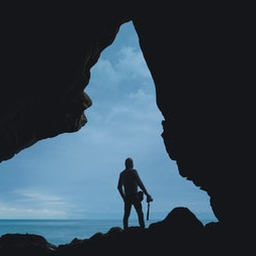

In [9]:
# What do the images look like? Let's sample one.
# -----------------------------------------------

# Change this to see different pictures

#########
i = 35
#########

image1 = os.listdir(train_dir)[i]
iPyImage(train_dir + image1)

# 4. Finding our color buckets
This is how we discretized the *ab* channels' color space into buckets for our model.

About color space discretization:

After reading some of the papers that inspired this project, prev. work found that if a model just predicts the *a* and *b* channels directly, the output predictions tend to be biased toward desaturated colors to minimize loss (*a,b* close to 0).

By discretizing the gamut of RGB colors projected into the AB channels of CIELAB color space, we turn the problem into a softmax color class prediction over the pixels. This has its up- and downsides. The upside is the color predictions are more vibrant given enough training; the latter being a longer training time we suspect.


## 4a. Algorithm for discretizing the image of RGB space when mapped to LAB colors

In [10]:
def get_bucket_id(ab_pixel):
    """ Given an ab coordinate, find the id of the bucket of
        that it belongs to.
        
        |ab_pixel|: np.array of shape (2,).
    """
    a = int(ab_pixel[0]) # floats cause a bug.
    b = int(ab_pixel[1])
    
    bucket_row = (a + 128) // GRID_SIZE
    bucket_col = (b + 128) // GRID_SIZE
    bucket_id = bucket_row * (256 // GRID_SIZE) + bucket_col
      
    return bucket_id
  
def discretize_ab_space():
    # initialize a blank array of (# buckets, 2).
    space = np.zeros(((256//GRID_SIZE)**2, 2))
    
    bucket_index = 0
    for a in xrange(-128, 128, GRID_SIZE):
        for b in xrange(-128, 128, GRID_SIZE):
            a_mid = float(a + GRID_SIZE / 2)
            b_mid = float(b + GRID_SIZE / 2)
            space[bucket_index] = a_mid, b_mid
            bucket_index += 1

    return space

def compute_bucket_maps(bucket2ab_map=None, ab2bucket_map=None):
    
    # If we have 228 buckets, the bucket at the 177th index could be bucket #210.
    # These maps keep track of the index in [0, 112) <-> the bucket id.
    global BUCKET_ID_TO_INDEX
    global BUCKET_INDEX_TO_ID
    
    # 1) Get our monte carlo ab color space.
    # Note: skimage.color's rgb2lab takes in RGB values normalized to [0,1].
    # Step sizes of 3 for R,G,B is granular enough for our purposes,
    #   in sampling RGB space.
    all_rgb_normed = [[r/255., g/255., b/255.] for r in xrange(0,256) \
                                               for g in xrange(0,256) \
                                               for b in xrange(0,256)]
    print("compute_bucket_maps(): finished getting all_rgb_normed")
    
    NUM_RGB_SAMPLES = len(all_rgb_normed)
    all_rgb_normed = np.array(all_rgb_normed)
    all_rgb_normed = all_rgb_normed[:, np.newaxis, :]        # (#rgb colors, 1, 3=rgb)
    assert all_rgb_normed.shape == (NUM_RGB_SAMPLES, 1, 3) #  new axis because skimage demands it.
    ab_colors = rgb2lab(all_rgb_normed)                    # (#rgb colors, 1, 3=lab)
    ab_colors = np.squeeze(ab_colors)[:,1:]                # (#rgb colors, 2=ab)
    assert ab_colors.shape == (NUM_RGB_SAMPLES, 2)
    
    # 2) Get our buckets. 
    # ab_buckets[bucket #] = (a,b) coord for that bucket, even if it isn't a valid RGB.
    ab_buckets_centers = discretize_ab_space()             # (#buckets, 2=ab)
    assert ab_buckets_centers.shape == (NUM_TOTAL_BUCKETS, 2)
    
    # 3) Now we calculate the closest bucket for each ab color.
    closest = [get_bucket_id(color) for color in ab_colors]
    valid_buckets = set(closest)
    
    # aside: for interpreting the softmax in the rainbowModel later, we need to know which neuron predicts which bucket
    BUCKET_ID_TO_INDEX = {bucket_id : i for i, bucket_id in enumerate(list(valid_buckets))}
    BUCKET_INDEX_TO_ID = {i : bucket_id for i, bucket_id in enumerate(list(valid_buckets))}
    debug(BUCKET_ID_TO_INDEX, "id to index")
    debug(BUCKET_INDEX_TO_ID, "index to id")
    
    # 4) Create the maps.
    bucket2ab_map = {bucket : tuple(ab_buckets_centers[bucket]) for bucket in valid_buckets}
    # Assert there are no repeats in the map
    assert len(bucket2ab_map.values()) == len(set(bucket2ab_map.values()))
    ab2bucket_map = {bucket2ab_map[bucket] : bucket for bucket in bucket2ab_map}
    assert len(ab2bucket_map.values()) == len(set(ab2bucket_map.values()))
    
    print ("There are %d final buckets." % len(bucket2ab_map))
    print ("There are %d final colors." % len(ab2bucket_map))
    
    return bucket2ab_map, ab2bucket_map

def plot_mapping(bucket2ab_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    for bucket in bucket2ab_map:
        a_mid = bucket2ab_map[bucket][0]
        a_low = a_mid - GRID_SIZE / 2
        b_mid = bucket2ab_map[bucket][1]
        b_low = b_mid - GRID_SIZE / 2

        lab_pixel = np.array([50., a_mid, b_mid])
        lab_pixel = np.reshape(lab_pixel, (1, 1, 3))
        rgb = tuple(lab2rgb(lab_pixel)[0][0])

        ax.add_patch(
            patches.Rectangle(
                (b_low, -a_low), 
                GRID_SIZE, 
                GRID_SIZE, 
                facecolor=rgb
            )
        )

    plt.xlim([-128, 128])
    plt.ylim([-128, 128])
    plt.show()

## 4b. Generate our bucket maps
Run the cells below. The first one is optional; set ``remove`` to ``True`` if you want to remove existing pickles and re-run the bucket map computation.

In [11]:
# Run this if you want to manually remove existing pickles, 
# and recompute the maps (e.g. to prove the code works).

##############
remove = True
##############

if remove:
  ! rm -f {model_metadata_dir + "*.pkl"}
  ! ls {model_metadata_dir}

compute_bucket_maps(): finished getting all_rgb_normed
<type 'dict'> len=112 id to index:
 {43: 0, 44: 1, 45: 2, 57: 3, 58: 4, 59: 5, 60: 6, 61: 7, 71: 8, 72: 9, 73: 10, 74: 11, 75: 12, 76: 13, 77: 14, 86: 15, 87: 16, 88: 17, 89: 18, 90: 19, 91: 20, 92: 21, 93: 22, 101: 23, 102: 24, 103: 25, 104: 26, 105: 27, 106: 28, 107: 29, 108: 30, 109: 31, 116: 32, 117: 33, 118: 34, 119: 35, 120: 36, 121: 37, 122: 38, 123: 39, 124: 40, 125: 41, 131: 42, 132: 43, 133: 44, 134: 45, 135: 46, 136: 47, 137: 48, 138: 49, 139: 50, 140: 51, 141: 52, 147: 53, 148: 54, 149: 55, 150: 56, 151: 57, 152: 58, 1
[... id to index output truncated]
<type 'dict'> len=112 index to id:
 {0: 43, 1: 44, 2: 45, 3: 57, 4: 58, 5: 59, 6: 60, 7: 61, 8: 71, 9: 72, 10: 73, 11: 74, 12: 75, 13: 76, 14: 77, 15: 86, 16: 87, 17: 88, 18: 89, 19: 90, 20: 91, 21: 92, 22: 93, 23: 101, 24: 102, 25: 103, 26: 104, 27: 105, 28: 106, 29: 107, 30: 108, 31: 109, 32: 116, 33: 117, 34: 118, 35: 119, 36: 120, 37: 121, 38: 122, 39: 123, 40: 124, 

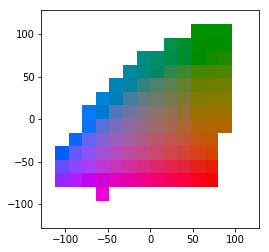

We have in the map 112 buckets.
Buckets loaded successfully!


In [12]:
"""
The script for loading our bucket maps.
If there are .pkl's of maps we've stored from a previous computation,
    load those.
Otherwise, run compute_bucket_maps() to get them, and dump into
    pickles for the future.
"""

# To open: `map = pickle.load(open(<filename>, 'r'))`
BUCKET2AB = model_metadata_dir + 'bucket2ab_map.pkl'
AB2BUCKET = model_metadata_dir + 'ab2bucket_map.pkl'
ID2INDEX  = model_metadata_dir + 'id2index_map.pkl'
INDEX2ID  = model_metadata_dir + 'index2id_map.pkl'

bucket2ab_map = None
ab2bucket_map = None

# No pickles found. Compute the maps.
if not os.path.isfile(BUCKET2AB) or not os.path.isfile(AB2BUCKET) or \
   not os.path.isfile(ID2INDEX) or not os.path.isfile(INDEX2ID):
  bucket2ab_map, ab2bucket_map = compute_bucket_maps()
  
  pickle.dump(bucket2ab_map, open(BUCKET2AB, 'wb'))
  pickle.dump(ab2bucket_map, open(AB2BUCKET, 'wb'))
  
  pickle.dump(BUCKET_ID_TO_INDEX, open(ID2INDEX, 'wb'))
  pickle.dump(BUCKET_INDEX_TO_ID, open(INDEX2ID, 'wb'))
  
# We found the pickles! Load them.
else:
  print("Loading buckets from pickle.")
  bucket2ab_map = pickle.load(open(BUCKET2AB, 'rb'))
  ab2bucket_map = pickle.load(open(AB2BUCKET, 'rb'))
  
  BUCKET_ID_TO_INDEX = pickle.load(open(ID2INDEX, 'rb'))
  BUCKET_INDEX_TO_ID = pickle.load(open(INDEX2ID, 'rb'))

plot_mapping(bucket2ab_map)
# --------------------------

print("We have in the map %d buckets." % len(bucket2ab_map))
if NUM_VALID_BUCKETS != len(bucket2ab_map):
  print("NUM_VALID_BUCKETS=%s does not match the number of buckets we computed."
         % str(NUM_VALID_BUCKETS))
  print("Setting NUM_VALID_BUCKETS=%d" % len(bucket2ab_map))
  NUM_VALID_BUCKETS = len(bucket2ab_map)

# bucket2ab_map: map of bucket id to (a, b)
# ab2bucket_map: map of (a, b) to bucket id
# id2index_map:  map of bucket id to it's index in the softmax vector
# 2index2id_map:  map of bucket index in softmax to it's id

print("Buckets loaded successfully!")

## 4c. Applying the Bucketing Scheme to Images
The following two functions are for turning an *Lab* image(s) into an array of bucket logits (with the schema described above in section 4), and the converse.

In [13]:
def discretize(images_ab):
  """ This is a preprocessing step, that will be used in converting 
      Y (ab image true labels) into buckets, so that we can calculate
      a loss in colorization_loss().
  
      |images_ab|: (m, H, W, 2) array representing ab channels of images.
  
      :return: (m, H, W) array where each entry is in BUCKET_ID_TO_INDEX.
               One of the NUM_VALID_BUCKETS color buckets we found.
  """
  if len(images_ab.shape) == 3:
    print("discretize(): detected only 3 dims, reshaping to (m=1,:,:,:)")
    images_ab = images_ab[np.newaxis,:,:,:]
    
  assert BUCKET_ID_TO_INDEX is not None
  
  m, H, W, _ = images_ab.shape
  images_d = np.zeros((m, H, W))

  for i in xrange(m):
    for h in xrange(H):
      for w in xrange(W):
        ab_pixel = images_ab[i,h,w]
        bucket_id = get_bucket_id(ab_pixel)
        images_d[i,h,w] = BUCKET_ID_TO_INDEX[bucket_id] # int in range [0, NVB)
  
  return images_d

# New name!
# ---------
ab_channels_to_bucket_indices = discretize

In [14]:
# This function will be called when we want to demo a predicted image.
# It takes an image with pixels labeled with buckets, and transforms it
#   into 2 color channels.

def inverse_discretize(images_d):
  """ The inverse of the above function. Maps the indicated bucket to
      the mean of that bucket.
      
      |images_d|: an array (m,H,W) with the color bucket *index=logit* 
                  assigned to each pixel.
                  
      :return: (m, H, W, 2) array with ab color values.
  """
  if len(images_d.shape) == 2:
    print("inverse_discretize(): detected only 2 dims, reshaping to (m=1,:,:)")
    images_d = images_d[np.newaxis,:,:]

  m, H, W = images_d.shape
  images_ab = np.zeros((m, H, W, 2))
  
  for i in xrange(m):
    for h in xrange(H):
      for w in xrange(W):
        bucket_index = images_d[i,h,w]
        bucket_id = BUCKET_INDEX_TO_ID[bucket_index]
        images_ab[i,h,w] = bucket2ab_map[bucket_id] # Sets to [a,b]
  
  return images_ab

# New name!
# ---------
bucket_indices_to_ab_channels = inverse_discretize

### 4ci. Testing the bucketing functions

Given an image, you should see what it looks like when pixel colors are mapped to the nearest bucket. It should be roughly the same as the image we last displayed (the indexes are both 35, unless they've been changed manually).

<type 'numpy.ndarray'> (1, 256, 256, 3) images out:
 [[[[ 10.78256111   8.           8.        ]
   [ 10.78256111   8.           8.        ]
   [ 10.78256111   8.           8.        ]
   ..., 
   [ 10.78256111   8.           8.        ]
   [ 10.78256111   8.           8.        ]
   [ 10.78256111   8.           8.        ]]

  [[ 10.78256111   8.           8.        ]
   [ 10.78256111   8.           8.        ]
   [ 10.78256111   8.           8.        ]
   ..., 
   [ 10.78256111   8.           8.        ]
   [ 10.78256111   8.           8.      
[... images out output truncated]


/usr/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


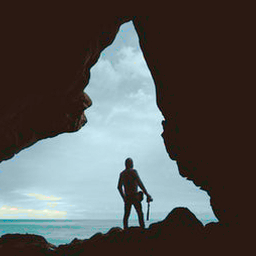

In [15]:
# Test if buckets look correct
#########
index = 35
#########

first_image_name = os.listdir(train_dir)[index]
image = load_img(train_dir + first_image_name)  # PIL image
images = np.array([img_to_array(image)])
images_normed = images - np.amin(images, axis=(1,2), keepdims=True)
images_normed = images_normed / np.amax(images_normed, axis=(1,2), keepdims=True)
images = rgb2lab(images_normed)

lchannel = images[:,:,:,0,np.newaxis]
images_ab = images[:,:,:,1:]

images_d = ab_channels_to_bucket_indices(images_ab)
images_out = bucket_indices_to_ab_channels(images_d)

images_out = np.concatenate((lchannel, images_out), axis=3)
debug(images_out, 'images out')
rgb_images = lab2rgb(images_out[0])

imsave(temp_dir + "test.png", rgb_images)
display(iPyImage(temp_dir + "test.png"))

## 4d. [Extension, Optional] Analyzing our training set data

We turn each image into a histogram of colors (112 bins according to our color discretization), represented as a 112-vector. Then we run K-means coloring to determine what are the main color profiles that appear in our training set, and hopefully learn a bit more about what can be gleaned from the distributions of colors.

E.g. do blue and green occur somewhat more frequently together because of outdoor scenes? What are the most prevalent combinations of hues, and in what kind of images do they occur?

__NOTE__ this may have memory errors running on the 9000+ images from the FloydHub training data, so only recommended for smaller sets of images.

### 4di. Exploring our data: What colors occur together in images of our dataset?


In [ ]:
def generate_bucket_histograms(images):
  """ Generates histograms of the buckets that images 
  """
  images_normed = images - np.amin(images, axis=(1,2), keepdims=True)
  images_normed = images_normed / np.amax(images_normed, axis=(1,2), keepdims=True)
  images_ab = rgb2lab(images_normed)[:,:,:,1:]
  images_disc = ab_channels_to_bucket_indices(images_ab)    # shape (m, H, W)

  m, H, W = images_disc.shape
  
  # Make a histogram of the colors in each image.
  histograms = np.zeros((m, NUM_VALID_BUCKETS))
  for i in xrange(m):
#     histogram = np.zeros(NUM_VALID_BUCKETS)
    for h in xrange(H):
      for w in xrange(W):
        bucket = int(images_disc[i,h,w])
        histograms[i][bucket] += 1
#     histograms.append(np.copy(histogram))

  print('Finished generating histograms')
  return np.array(histograms)

In [ ]:
# K-means Clustering with our image histograms (data points)
# ----------------------------------------------------------

import random as rand

NUM_CLUSTERS = 5

def cluster_histograms(images_histogram):
  print('Starting histogram clustering')
  
  m, n = images_histogram.shape
  print m, n
  
  centroids = []
  for i in range(NUM_CLUSTERS):
    r = rand.randint(0, m - 1)
    centroids.append(images_histogram[r])
    
  clusters = [[] for i in range(NUM_CLUSTERS)]
  
  def cluster(centroids):
    clusters = [[] for i in range(NUM_CLUSTERS)]
    for i in range(m):
      min_dist = float('inf')
      min_cent = 0
      vec = images_histogram[i]
      for cent_ind, cent in enumerate(centroids):
        dist = np.linalg.norm(vec - cent)
        if dist < min_dist:
          min_dist = dist
          min_cent = cent_ind
      clusters[min_cent].append(i)
    return clusters

  def recenter(curr_cents, clusters):
    new_cents = []
    for pts in clusters:
      if pts == []: continue
      cluster_vec = [images_histogram[i] for i in pts]
      new_cent = np.mean(cluster_vec, axis=0)
      new_cents.append(new_cent)
    return new_cents, np.array_equal(curr_cents, new_cents)

  num_iters = 0
  while True:
    print('iter %d' % num_iters)
    clusters = cluster(centroids)
    centroids, converged = recenter(centroids, clusters)
    if converged:
      print 'converged at iter %d'%num_iters
      return centroids, clusters
    num_iters += 1

In [ ]:
def plot_histogram_mapping(centroids):
    # use index to get a, b
    debug(centroids, 'centroids')
    counter = 0
    for centroid in centroids:
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal')
        
        max_freq = np.max(centroid)
        print max_freq
        print len(centroid)
        print "-" * 20
        
        for ind in range(len(centroid)):
          bucket = BUCKET_INDEX_TO_ID[ind]
          freq = centroid[ind]
          a_mid = bucket2ab_map[bucket][0]
          a_low = a_mid - GRID_SIZE / 2
          b_mid = bucket2ab_map[bucket][1]
          b_low = b_mid - GRID_SIZE / 2
          
#           import math
#           if freq > 0:
#             norm_freq = math.log(freq) / math.log(max_freq)
#           else:
#             norm_freq = 0
#           # gradient 0 to 0.5
#           norm_freq = min(1, 2 * norm_freq)
#           curr_color = str(norm_freq)
          
          lab_pixel = np.array([50., a_mid, b_mid])
          lab_pixel = np.reshape(lab_pixel, (1, 1, 3))
          rgb = tuple(lab2rgb(lab_pixel)[0][0])
          if freq == 0:
            rgb = '0'

          ax.add_patch(
              patches.Rectangle(
                  (b_low, -a_low), 
                  GRID_SIZE, 
                  GRID_SIZE, 
                  facecolor=rgb
              )
          )

        plt.xlim([-128, 128])
        plt.ylim([-128, 128])
#         plt.show()
        plt.savefig(temp_dir + 'image' + str(counter) + '.png')
        plt.gcf().clear()
    
        counter += 1

In [ ]:
bucket_histograms = generate_bucket_histograms(load_data(train_dir)) # shape (m, NUM_VALID_BUCKETS=112)
centroids, clusters = cluster_histograms(bucket_histograms)
plot_histogram_mapping(centroids)

In [ ]:
display(iPyImage(temp_dir + 'image0.png'))
display(iPyImage(temp_dir + 'image1.png'))
display(iPyImage(temp_dir + 'image2.png'))
display(iPyImage(temp_dir + 'image3.png'))
display(iPyImage(temp_dir + 'image4.png'))

# 5. RainbowNet

The code directly (vaguely defined) related to RainbowNet itself is below.

## 5a. The Inception ResNet Fusion

We're going to be using Google's Inception ResNet v2 to augment our CNN. This model has been highly trained on millions of examples, and can detect features that would be useful in colorizing our test images. The fusion of IRNet features with our CNN will come later in RainbowNetModel(). For now, these functions load the model and set up predictions.



In [16]:
def load_inception_net():
  inception = InceptionResNetV2(weights='imagenet', include_top=True)
  inception.graph = tf.Graph() # Make a new graph for IRN2
  
  # Freeze weights for InceptionNet.
  for layer in inception.layers:
    layer.trainable = False  
  return inception

In [17]:
def create_inception_embedding(grayscaled_rgb):
  """ One forward pass through the Inception ResNet.
      |grayscaled_rgb|: the images we are embedding in grayscale. 
      :return: (m, 1000) vector.
  """
  # Resize all the images to (299, 299, 3).
  grayscaled_rgb_resized = resize_images(grayscaled_rgb, (299, 299, 3))
  # preprocessing for the Inception resnet
  grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)

  embed = inception.predict(grayscaled_rgb_resized)
  
  return embed

In [18]:
# initialize inception resnet, for use in |preprocess_data()|
# -----------------------------------------------------------
try:
    assert type(inception) == keras.engine.training.Model
except (NameError, AssertionError):  
    inception = load_inception_net()

print ("Loaded Inception Resnet model for generating image embeddings.")

Loaded Inception Resnet model for generating image embeddings.


## 5b. Pre-processing the data for RainbowNet
These are the functions that load the data, for training and for test.

```preprocess_data()``` then processes them for input into our CNN. This involves converting to *Lab* and separating the channels, running through Inception Resnet v2, and normalizing the *L* channel input.

In [19]:
def preprocess_data(images, verbose=False):
    """ Preprocess the data for input into our rainbownet model.
    """
    
    if verbose: print("preprocess_data(): obtained %d images." % len(images))

    # Resize them to (224,224)
    if verbose: print("preprocess_data(): Resizing")
    images_resized = resize_images(images, (224, 224, 3))
    
    # Get the inception embeddings from grayscaled images. 
    #   This will be part of our passed in input.
    if verbose: print("preprocess_data(): Creating inception embeddings")
    # NOTE: Try without fusion!
    #grayscaled_images = gray2rgb(rgb2gray(images_resized))
    #embs = create_inception_embedding(grayscaled_images) # a numpy array

    # Normalize the resized images (which are in RGB) to [0,1] to prepare for rgb2lab.
    #   Otherwise, the lab values are in a wacky domain, and it's hard to manage.
    images_normed = images_resized - np.amin(images_resized, axis=(1,2), keepdims=True)
    images_normed = images_normed / np.amax(images_normed, axis=(1,2), keepdims=True)
    
    # Transform to lab. Separate the l- and ab- channels
    if verbose: print("preprocess_data(): Separating L and ab channels")
    images_lab = rgb2lab(images_normed)
    images_l = images_lab[:,:,:,0,np.newaxis]     # shape (m, H, W, n_frames=1 for now)
    images_ab = images_lab[:,:,:,1:]              # shape (m, H, W, 2) 
    
    # Normalize L channel to be between 0, 1. L ranges from 0 to 100.
    # Temporarily take it out, see if it improves the NN
    #if verbose: print("preprocess_data(): Normalizing L channel to [0,1]")
    #images_l /= 100

    # Create X, composed of L channel + the embedding
    X_images = images_l
    # NOTE: Try without fusion!
    #X_embeds = embs

    # Create Y, including discretizing the ab image
    if verbose: print("preprocess_data(): discretizing Y")
    Y = discretize(images_ab)       # shape (m, H, W)
    
    if verbose: print("preprocess_data(): done. returning X_img, X_emb, Y")
    # NOTE: Try without fusion!
    #return X_images, X_embeds, Y
    return X_images, Y

## 5c. Defining our per-pixel softmax loss
Our colorization loss is the softmax cross-entropy between the multinomial color distributions of every pixel in ```y_true``` and ```y_pred``` over all pixels (H,W), over all images in the minibatch. Inspired by the colorization paper, to solve issues other losses like desaturation from MSE.

A workaround: a custom Keras loss function forces you to have parameters ``y_true``, ``y_pred`` that are the same in tensor dimension. We have sparse labels, so this doesn't work. We also need a custom loss to sum over the pixels; ``tf.nn.sparse_softmax_cross_entropy`` won't work. We therefore pass in our loss in the model definition instead of the ``model.compile()`` function, and use dummy losses during compilation.

In [20]:
def colorization_loss(y_true, y_pred):
  """ |y_true|: Our true colors. A tensor (batch_size, H, W) with entries 
                specifying one of the buckets that pixel's color is in.
      |y_pred|: A (batch_size, H, W, NUM_VALID_BUCKETS) tensor with last dimension a
                softmax over bucket probabilities.
  
      This loss involves computing the softmax cross-entropy over pixel's
        predicted color bucket, over all images in the batch.
  """

  return Lambda(lambda (_yt, _yp): K.sum(K.sparse_categorical_crossentropy(_yt, _yp)),
                  output_shape=lambda (_yt, _yp): _yt,
                  name='loss')([y_true, y_pred])
  

## 5d. Defining our RainbowNet architecture
Note the "input" of ``y_true`` and our auxiliary output layer of the loss. See previous header cell for an explanation.


In [21]:
def RainbowNetModel():
  # Inspired by the colorization paper's architecture. Keep in mind they trained
  #   on ImageNet though.
    
  # Input will have to be modified for doing image seqs. 
  #   In particular the volume is probably not 1 channel, but n_frames channels.
  
  # NOTE: Try without fusion!
  #embedding_input = Input(shape=(1000,), name='embed_input')
  encoder_input = Input(shape=(224, 224, 1,), name='image_input')
  y_true = Input(shape=(224, 224,), name='y_true')

  # The number of times we do "strides=2" should be the 
  #   same as the number of times we do Upsampling2D. 
  
  # Encoder
  # -------
  encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', name='enc_1-1', kernel_initializer='he_normal')(encoder_input)
  encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2, name='enc_1-2down', kernel_initializer='he_normal')(encoder_output) #112
  #encoder_output = BatchNormalization(name='enc_1-bn')(encoder_output)
  
  encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', name='enc_2-1', kernel_initializer='he_normal')(encoder_output)
  encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2, name='enc_2-2down', kernel_initializer='he_normal')(encoder_output) #56
  #encoder_output = BatchNormalization(name='enc_2-bn')(encoder_output)
  
  encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', name='enc_3-1', kernel_initializer='he_normal')(encoder_output)
  encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2, name='enc_3-2down', kernel_initializer='he_normal')(encoder_output) #28
  #encoder_output = BatchNormalization(name='enc_3-bn')(encoder_output)
  
  # May have to reduce layers if we don't have enough training data, to avoid overfitting.
  encoder_output = Conv2D(512, (3,3), activation='relu', padding='same', name='enc_4-1', kernel_initializer='he_normal')(encoder_output)
  encoder_output = Conv2D(512, (3,3), activation='relu', padding='same', name='enc_4-2', kernel_initializer='he_normal')(encoder_output)
  #encoder_output = BatchNormalization(name='enc_4-bn')(encoder_output)


#   # Fusion
#   # ------
#   fusion_output = RepeatVector(28 * 28, name='fuse_repeat')(embedding_input) 
#   fusion_output = Reshape(([28, 28, 1000]), name='fuse_reshape')(fusion_output)
#   fusion_output = concatenate([encoder_output, fusion_output], axis=3, name='fuse_concat')  # Stack along thickness dimension
  
#   # A volume that solidifies the fusion from the inception-resnet vectors + our previous volume:
#   fusion_output = Conv2D(512, (1, 1), activation='relu', padding='same', name='fuse_conv2d')(fusion_output) 


  #Decoder
  # May have to reduce layers if we don't have enough training data, to avoid overfitting?
  decoder_output = Conv2D(256, (3,3), activation='relu', padding='same', name='dec_1-1', kernel_initializer='he_normal')(encoder_output) # 28
  decoder_output = Conv2D(256, (3,3), activation='relu', padding='same', name='dec_1-2', kernel_initializer='he_normal')(decoder_output)
  #decoder_output = BatchNormalization(name='dec_1-bn')(decoder_output)
  decoder_output = UpSampling2D((2, 2), name='dec_1-up')(decoder_output) # 56
  
  decoder_output = Conv2D(128, (3,3), activation='relu', padding='same', name='dec_2-1', kernel_initializer='he_normal')(decoder_output)
  decoder_output = Conv2D(128, (3,3), activation='relu', padding='same', name='dec_2-2', kernel_initializer='he_normal')(decoder_output)
  #decoder_output = BatchNormalization(name='dec_2-bn')(decoder_output)
  decoder_output = UpSampling2D((2, 2), name='dec_2-up')(decoder_output) # 112
  
  decoder_output = Conv2D(64, (3,3), activation='relu', padding='same', name='dec_3-1', kernel_initializer='he_normal')(decoder_output)
  decoder_output = Conv2D(64, (3,3), activation='relu', padding='same', name='dec_3-2', kernel_initializer='he_normal')(decoder_output)
  #decoder_output = BatchNormalization(name='dec_3-bn')(decoder_output)
  decoder_output = UpSampling2D((2, 2), name='dec_3-up')(decoder_output) # 224
  
  # Two more layers to bring it up closer to the number of dims in the softmax vector
  decoder_output = Conv2D(128, (3,3), activation='relu', padding='same', name='dec_4-1', kernel_initializer='he_normal')(decoder_output)
  decoder_output = Conv2D(128, (3,3), activation='relu', padding='same', name='dec_4-2', kernel_initializer='he_normal')(decoder_output)

  softmax_output = Conv2D(NUM_VALID_BUCKETS, (3,3), activation=softmax, padding='same', name='dec_5_final_output', kernel_initializer='he_normal')(decoder_output)
  loss = colorization_loss(y_true, softmax_output)
  
  #model = Model(inputs=[encoder_input, embedding_input, y_true], outputs=[loss, softmax_output])
  model = Model(inputs=[encoder_input, y_true], outputs=[loss, softmax_output])
  model.add_loss(loss) # axis=None
  return model

# try:
#     rainbowModel
#     del rainbowModel
# except:
#     print("Initializing Rainbow Model")
rainbowModel = RainbowNetModel()
rainbowModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
enc_1-1 (Conv2D)                (None, 224, 224, 64) 640         image_input[0][0]                
__________________________________________________________________________________________________
enc_1-2down (Conv2D)            (None, 112, 112, 64) 36928       enc_1-1[0][0]                    
__________________________________________________________________________________________________
enc_2-1 (Conv2D)                (None, 112, 112, 128 73856       enc_1-2down[0][0]                
__________________________________________________________________________________________________
enc_2-2dow

## 5e. Helpers for Rainbownet functionality

### 5ei. Saving and loading the model

In [22]:
def save_model(model, model_save_path, extension=""):
  model.save_weights(model_save_path + model_name + extension + ".h5")

def load_existing_weights(model, weights_path):

  if not os.path.isfile(weights_path):
    print("The model at path %s was not found." % weights_path)
    quit()

  model.load_weights(weights_path)
  return model

## 5f. Time to train our RainbowNet model!
Now we can run our model. It will save its parameters after every training epoch, and after every 50 minibatches.

### 5fi. Method to try a prediction on an image with our model

In [27]:
# The predictions are (m, H, W, NUM_VALID_BUCKETS = softmax dim).
# We need to process these so they're interpretable as color images.

def try_one_prediction(rainbowModel, epoch, index=0, name=None, train_mode=False, validation_mode=False, preprocess_verbose=True):
    the_directory = test_dir
    if train_mode:
        the_directory = train_dir
    elif validation_mode:
        the_directory = validation_dir
    
    image_name = os.listdir(the_directory)[index]
    if name is not None:
        image_name = name
    
    image = load_img(the_directory + image_name)  # PIL image
    image = np.array([img_to_array(image)]).astype(int)

    #X_test_img, X_test_emb, Y_test = preprocess_data(image, verbose=True)
    X_test_img, Y_test = preprocess_data(image, verbose=preprocess_verbose)
    
    # Assume we're already inside a tensorflow session
    _loss, predictions = rainbowModel.predict({'image_input': X_test_img,
                                                 #'embed_input': X_test_emb,
                                                 'y_true': Y_test})

    predicted_bucket_indices = np.argmax(predictions, axis=3)
    if preprocess_verbose: debug(predicted_bucket_indices, "predicted indices")

    # Display / output the predictions.
    output_images_ab = inverse_discretize(predicted_bucket_indices)
    output_images_lab = np.concatenate((X_test_img, output_images_ab), axis=3) # add the L channel back

    # save one image
    # NOTE: we removed preprocessing reduce by 100, so this is no longer neces.
    image_sample = output_images_lab[0]
    #image_l = image[:,:,0]
    #image_l *= 100
    #image[:,:,0] = image_l

    image_rgb = lab2rgb(image_sample)
    filename = "rainbow_img_prediction_epoch_%s.jpg" % str(epoch)
    if train_mode:
        filename = "rainbow_img_prediction_TRAIN_epoch_%s.jpg" % str(epoch)
    if validation_mode:
        filename = "rainbow_img_prediction_VALIDATE_epoch_%s.jpg" % str(epoch) # TODO(owang): Fix this train/dev flag param
    imsave(results_dir + filename, image_rgb)

    # Display what we have in results_dir.
    path = results_dir + filename
    display(iPyImage(filename=path))

### 5fii. [For debugging the model] Getting gradients

In [24]:
def get_gradient_function(model):
    """Returns:
        - tensors for all trainable weights in the model
        - a function that grabs the gradients with respect to a particular input

    Parameters
    -----------
    model : a keras model instance

    SOURCE: https://github.com/fchollet/keras/issues/2226
    """
    # Find all trainable tensors in the model
    weights = [tensor for tensor in model.trainable_weights]# if model.get_layer(tensor.name[:-2]).trainable]
    
    # Get gradients of the loss with respect to the weights
    optimizer = model.optimizer
    grad_tensors = optimizer.get_gradients(model.total_loss, weights)
    
    # for reference: inputs=[encoder_input, embedding_input, y_true]
    input_tensors = [rainbowModel.inputs[0], 
                     rainbowModel.inputs[1], 
                     rainbowModel.inputs[2], # input data
                     K.learning_phase()] 
    return weights, K.function(inputs=input_tensors, outputs=grad_tensors)

### 5fiii. The training script.

Run this cell below to train.

__Predicting with the model:__

If you want to use the weights we trained for 24 epochs to predict instead, skip this next cell and proceed to the ones beneath.

In [ ]:
# Run the model!
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  try: # We might have already instantiated the model earlier in the definition cell for a summary.
    rainbowModel
  except NameError:
    rainbowModel = RainbowNetModel()


  # load previous weights if we have them
  # If we want to start training from a previous point, specify the weights file name below

  #############################################################
  weights_path = model_chkpt + "rainbownet12-11-17-36-31_epoch-24.h5"
  #############################################################

  if os.path.exists(weights_path):
    print("Before we start, loading existing weights at %s" % weights_path)
    load_existing_weights(rainbowModel, weights_path)
  else:
    print("No existing weights at %s found to equip. Leaving it as is." % weights_path)


  # We compile with no loss. The loss is added manually in the model definition.
  # This is because a custom loss function had trouble when the dimensions of y_pred and y_true do not match.
  # epsilon 0.01 because otherwise loss explodes after training for a long time
  adam = keras.optimizers.Adam(lr=0.0003, epsilon=0.01)
  rainbowModel.compile(optimizer=adam, 
                       loss=[None, None], loss_weights=[0., 0.])

  datagen_train = ImageDataGenerator()
  datagen_valid = ImageDataGenerator()

  # store losses per epoch in dict with key=epoch
  train_loss_dict = {}
  valid_loss_dict = {}
  
  global completed_epochs
  #######################
  completed_epochs = 24 # manually set this for naming
  #######################
  
  # https://fizzylogic.nl/2017/05/08/monitor-progress-of-your-keras-based-neural-network-using-tensorboard/
  tensorboard = TensorBoard(log_dir="logs/{}".format(datetime.now()))
  writer = tf.summary.FileWriter("/logs/histograms")
  """Uncomment to actually record logs^"""
  # NOTE(owang): set up gradient visualization.
  # https://github.com/fchollet/keras/issues/6215
  # https://github.com/fchollet/keras/issues/2226#issuecomment-259004640
#   trainable_weights, get_gradients = get_gradient_function(rainbowModel)
  # usage: gradients = get_gradients(input)
        
  num_epochs = 100
  for e in range(completed_epochs, completed_epochs + num_epochs):
    print('\n========== Epoch %d! ==========' % e)
    
    # Train. Do one epoch over training set
    # -------------------------------------
    images_per_epoch = len(os.listdir(train_dir))
    total_num_batches = np.ceil(images_per_epoch / (1.0*BATCH_SIZE))
    print("We have %d images per epoch." % images_per_epoch)
    print("We have %d batches per epoch." % total_num_batches)
    
    training_losses = []
    batch_num = 1
    for images_batch in datagen_train.flow_from_directory(data_dir, batch_size=BATCH_SIZE, classes=['Train'], class_mode=None):
        print("E%d: batch %d/%d" % (e, batch_num, total_num_batches))
        #X_train_img, X_train_emb, Y_train = preprocess_data(images_batch.astype(int))
        X_train_img, Y_train = preprocess_data(images_batch.astype(int))
        
        batch_input = {'image_input': X_train_img,
                       #'embed_input': X_train_emb,
                       'y_true': Y_train}
        history_train = rainbowModel.fit(batch_input,
                                         batch_size=BATCH_SIZE,
                                         verbose=1,
                                         callbacks=[tensorboard])
  
        curr_loss = history_train.history['loss'][0]         # Because there's only "1 batch" in this "epoch", list of 1 float
        avg_loss = curr_loss / float(images_batch.shape[0])  # otherwise small edge batches are outliers
        training_losses.append(avg_loss)
        
        # https://docs.floydhub.com/guides/jobs/tensorboard/
        tf.summary.scalar('avg_loss', avg_loss)
        # Gradient visualization.
#         grads = zip(trainable_weights, get_gradients([X_train_img[:0], X_train_emb[:0], Y_train[:0], 0]))
#         for var, grad in grads:
#             print var.name.replace(':', '_'), np.sum(grad)
        
        if batch_num % 50 == 0:
          save_model(rainbowModel, model_chkpt, extension="_tmp_%d_%d" % (e, batch_num))
          print("Saved temporary model during training")
        
        batch_num += 1
        if batch_num > total_num_batches:
          # The epoch has ended! Break loop by hand, cause datagen doesn't stop
          break
        
    # Save our progress.
    now = datetime.now()
    timestamp = now.strftime("%m-%d-%H-%M-%S")
    extension = timestamp + "_epoch-" + str(e)
    save_model(rainbowModel, model_chkpt, extension=extension)
    print("Saved model at end of epoch %d with extension %s." % (e, extension))
    
    # add the avg training loss in this epoch to the dict
    avg_training_loss = np.average(training_losses)
    train_loss_dict[e] = avg_training_loss
    print("Average training loss of %f." % avg_training_loss)
    
    # Validate at the end of an epoch
    # -------------------------------
    images_per_epoch = len(os.listdir(validation_dir))
    total_num_batches = np.ceil(images_per_epoch / (1.0*BATCH_SIZE))
    print("(V) We have %d images for validation." % images_per_epoch)
    print("(V) We have %d batches for validation." % total_num_batches)
    
    validation_losses = []
    batch_num = 1
    print("(V) Training done, starting evaluation on dev/validation set.")
    for images_batch in datagen_valid.flow_from_directory(data_dir, batch_size=BATCH_SIZE, classes=['Validation'], class_mode=None):
      print("(V) E%d: batch %d/%d, dims %s" % (e, batch_num, total_num_batches, str(images_batch.shape)))

      #X_train_img, X_train_emb, Y_train = preprocess_data(images_batch.astype(int))
      X_train_img, Y_train = preprocess_data(images_batch.astype(int))
      validation_loss = rainbowModel.evaluate({'image_input': X_train_img,
                                               #'embed_input': X_train_emb,
                                               'y_true': Y_train})
      avg_loss = validation_loss / float(images_batch.shape[0])
      validation_losses.append(avg_loss)
      
      batch_num += 1
      if batch_num > total_num_batches:
        # Validation done. Break loop by hand again
        break

    avg_validation_loss = np.average(validation_losses)
    valid_loss_dict[e] = avg_validation_loss
    print("(V) Avg validation loss of %f." % avg_validation_loss)

    losses_dir = results_dir + "epoch_%d_losses/" % e
    ! mkdir {losses_dir}
    vl_location = losses_dir + "valid_loss_dict.pkl"
    tl_location = losses_dir + "train_loss_dict.pkl"
    pickle.dump(train_loss_dict, open(tl_location, 'wb'))   # We use these dicts to graph the validation/train loss over epochs later
    pickle.dump(valid_loss_dict, open(vl_location, 'wb'))
    
    # Make a prediction at the end of the epoch,
    # to see what the colors are now like
    # ------------------------------------------
    try_one_prediction(rainbowModel, e)
    try_one_prediction(rainbowModel, e, train_mode=True)
    
    completed_epochs += 1
  # Plotting:
  #https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

## 5g. Displaying our predictions

Once the model is done, you can try to predict on a few (or all) of the images and see what kind of colorings you recieve.

__NOTE:__ If you skipped the training cell and have gotten to this part, please load the epoch 24 rainbownet weights before predicting - otherwise the model will still be randomly initialized!

Predicting on the Test set.
-----------------------------
<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[35 35 35 ..., 46 47 47]
  [35 35 35 ..., 46 46 47]
  [35 35 35 ..., 46 47 47]
  ..., 
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]]]


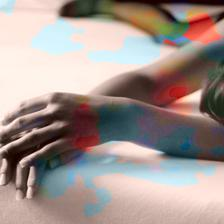

<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[46 46 46 ..., 47 47 47]
  [46 46 46 ..., 47 47 47]
  [46 46 46 ..., 47 47 47]
  ..., 
  [35 35 35 ..., 47 47 47]
  [46 35 35 ..., 47 47 47]
  [46 46 35 ..., 47 47 47]]]


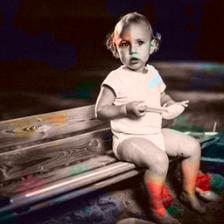

<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[46 46 46 ..., 35 35 35]
  [46 46 46 ..., 35 35 35]
  [46 46 46 ..., 35 35 35]
  ..., 
  [35 35 35 ..., 47 47 47]
  [35 35 35 ..., 47 47 47]
  [47 47 35 ..., 47 47 47]]]


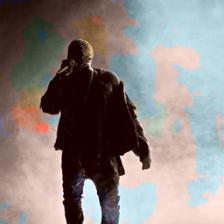

<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 35]
  ..., 
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]]]


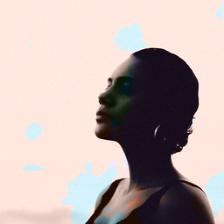

<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  ..., 
  [46 46 46 ..., 46 46 46]
  [46 46 46 ..., 46 46 46]
  [46 46 46 ..., 46 46 46]]]


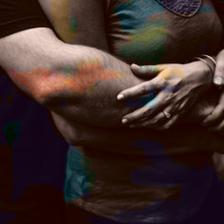

Predicting on the Validation set.
-----------------------------
<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  ..., 
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]]]


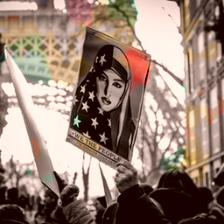

<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[46 46 46 ..., 46 46 47]
  [46 46 46 ..., 46 46 46]
  [46 46 46 ..., 46 46 46]
  ..., 
  [46 46 46 ..., 46 46 46]
  [46 46 46 ..., 46 46 46]
  [46 46 46 ..., 46 46 46]]]


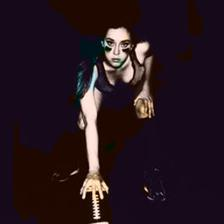

<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  ..., 
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]]]


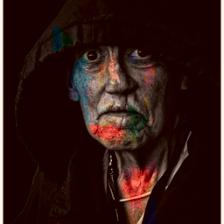

<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[47 47 47 ..., 36 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  ..., 
  [35 35 35 ..., 35 35 35]
  [46 35 46 ..., 35 35 35]
  [46 46 35 ..., 35 35 35]]]


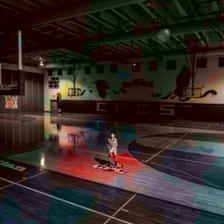

<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[35 35 46 ..., 47 47 47]
  [35 35 35 ..., 47 47 47]
  [35 35 35 ..., 47 47 47]
  ..., 
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]]]


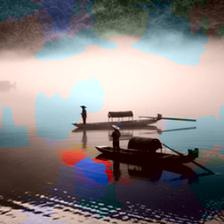

Predicting on the Train set.
-----------------------------
<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[47 47 47 ..., 46 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  ..., 
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]]]


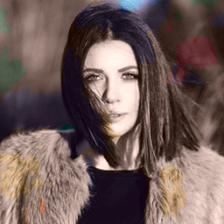

<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[46 46 46 ..., 47 47 47]
  [46 46 46 ..., 47 47 47]
  [46 46 46 ..., 47 47 47]
  ..., 
  [47 36 36 ..., 47 47 47]
  [47 36 36 ..., 47 47 47]
  [47 47 36 ..., 47 47 47]]]


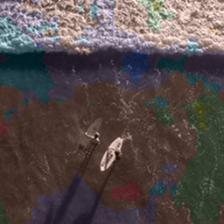

<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[34 34 34 ..., 34 34 34]
  [34 34 34 ..., 34 34 34]
  [34 34 34 ..., 34 34 34]
  ..., 
  [35 35 35 ..., 47 47 47]
  [35 35 35 ..., 47 47 47]
  [35 35 35 ..., 47 47 47]]]


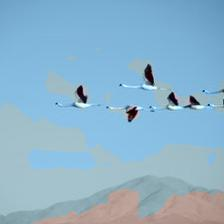

<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[36 36 36 ..., 36 36 36]
  [36 36 36 ..., 36 36 36]
  [36 36 36 ..., 36 36 36]
  ..., 
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]]]


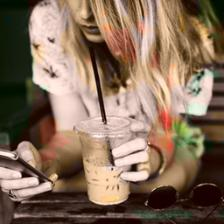

<type 'numpy.ndarray'> (1, 224, 224) predicted indices:
 [[[35 35 35 ..., 35 35 35]
  [35 35 35 ..., 35 35 35]
  [35 35 35 ..., 35 35 35]
  ..., 
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]
  [47 47 47 ..., 47 47 47]]]


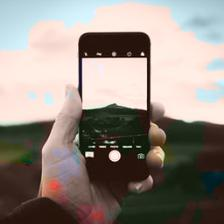

In [28]:
# The index of the image in test_dir we want to show.
# idx = 8

#########
stop_early_when_predicting = True
early_stop_index = 5
#########

# Uncomment the lines below to load pretrained weights! 
# Esp. if haven't run the training cell above (which loaded weights).
#########################
weights_path = model_chkpt + "rainbownet12-11-17-36-31_epoch-24.h5"
load_existing_weights(rainbowModel, weights_path)
#########################

# Predict on test set
print("Predicting on the Test set.\n-----------------------------")
num_images = len(os.listdir(test_dir)) if not stop_early_when_predicting else early_stop_index
for i in xrange(num_images):
    try_one_prediction(rainbowModel, 2000, index=i, train_mode=False, preprocess_verbose=False)

# Predict on validation set
print("Predicting on the Validation set.\n-----------------------------")
num_images = len(os.listdir(validation_dir)) if not stop_early_when_predicting else early_stop_index
for i in xrange(num_images):
    try_one_prediction(rainbowModel, 2000, index=i, validation_mode=True, preprocess_verbose=False)

# Predict on train set
print("Predicting on the Train set.\n-----------------------------")
num_images = len(os.listdir(train_dir)) if not stop_early_when_predicting else early_stop_index
for i in xrange(num_images):
    try_one_prediction(rainbowModel, 2000, index=i, train_mode=True, preprocess_verbose=False)
    if i == 200:
        break # Too many images in train_dir, no need to predict and display all of them

## 6. Baseline for comparison to RainbowNet

We implemented a simple baseline for comparison. 2 layer FCNN.

__NOTE:__ To try this, it's best to use the toy dataset example of the dog. The 9200 images from FH's dataset can cause memory errors sometimes, esp. if rainbownet was run before these cells.

In [33]:
def preprocess_baseline_data(images):
    debug(images)
    images_resized = resize_images(images, (224, 224, 3))
    X = rgb2lab(1.0 / 255 * images_resized)[:,:,:,0]
    Y = rgb2lab(1.0 / 255 * images_resized)[:,:,:,1:] / 128.
    
    X = X.reshape((len(X), np.prod(X.shape[1:])))
    Y = Y.reshape((len(Y), np.prod(Y.shape[1:])))
    return X, Y

In [34]:
def BaselineModel():
    inputs = Input(shape=(224 * 224,))
    encoded = Dense(224, activation='relu')(inputs)
    decoded = Dense(224 * 224 * 2, activation='tanh')(encoded)
    return Model(inputs, decoded)

In [ ]:
# Load the training data
images_train = load_data(train_dir) # CHANGE TO train_dir LATER
X_train, Y_train = preprocess_baseline_data(images_train)
print("Loaded X_train " + str(X_train.shape))
print("Loaded Y_train " + str(Y_train.shape))

# Load the test data
images_test = load_data(test_dir)
X_test, Y_test = preprocess_baseline_data(images_test)
print("Loaded X_test " + str(X_test.shape))
print("Loaded Y_test " + str(Y_test.shape))

# Initialize our baseline model, and train it
baselineModel = BaselineModel()
baselineModel.compile(optimizer='sgd', loss='mean_squared_error') #param: lr=12345.
baselineModel.fit(x=X_train, y=Y_train, batch_size=2, epochs=5)

print('===')

# Evaluate on the test set, and print our loss.
print baselineModel.evaluate(X_test, Y_test, batch_size=1)
test_output = baselineModel.predict(X_test)# * 128 * 128 * 128

# debug(test_output[0], "test_output")   # The (224*224*2)-vector that the baseline predicted from X_test[0]
# debug(Y_test[0], "Y_test")        # The ground truth, Y_test[0], corresponding to it.

# Save the results of prediction (in test_output) into the results_dir.
num_test_examples = len(X_test)
for i in range(num_test_examples):
    # The empty array holding our formatted-into-a-picture result
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = X_test[i].reshape((224, 224))                        # Set the L channel
    cur[:,:,1:] = test_output[i].reshape((224, 224, 2)) * 128         # Set the ab channels as our prediction
    imsave(results_dir + "img_" + str(i) + ".png", lab2rgb(cur))      # Save it.
    cur[:,:,1:] = Y_test[i].reshape((224, 224, 2)) * 128              # Set the ab channels as ground truth
    imsave(results_dir + "img_" + str(i) + "_og.png", lab2rgb(cur))   # Save it too.
    break

In [ ]:
from IPython.display import Image

# Display what we have in results_dir.
for filename in os.listdir(results_dir):
  print filename
  display(Image(results_dir + filename))

In [ ]:
test_output